#### Topic Modeling on Article data

In [44]:
import pandas as pd
import numpy as np

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
content = pd.read_csv('../data/platform_content.csv')

In [47]:
content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [48]:
no_dups = content.sort_values('event_timestamp').drop_duplicates(subset=['title', 'text_description'], keep='last')

In [49]:
no_dups.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,content_present,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [50]:
no_dups.interaction_type.value_counts()

content_present       2969
content_pulled_out      57
Name: interaction_type, dtype: int64

In [51]:
no_dups[no_dups['title'] == "Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's"]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


In [52]:
content[content['title'] == "Ethereum, a Virtual Currency, Enables Transactions That Rival Bitcoin's"]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en


Makes sense

In [53]:
content = no_dups

Drop everything except the text.

In [54]:
trimmed = content[['title', 'text_description', 'interaction_type']]

In [55]:
trimmed.head()

,title,text_description,interaction_type
1,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present
2,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present
3,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present
4,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present
5,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present


Preprocessing

In [57]:
trimmed['text_no_punc'] = trimmed.text_description.str.replace(r'[^\w\s]+', '')

In [58]:
trimmed.head()

,title,text_description,interaction_type,text_no_punc
1,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,All of this work is still very early The first...
2,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,The alarm clock wakes me at 800 with stream of...
3,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,Were excited to share the Google Data Center 3...
4,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,The Aite Group projects the blockchain market ...
5,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,One of the largest and oldest organizations fo...


In [59]:
# Convert trimmed.text_no_punc to lowercase and assign to trimmed.text_no_punc_lower
trimmed['text_no_punc_lower'] = trimmed.text_no_punc.str.lower()

In [60]:
trimmed.head()

,title,text_description,interaction_type,text_no_punc,text_no_punc_lower
1,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present,All of this work is still very early The first...,all of this work is still very early the first...
2,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,content_present,The alarm clock wakes me at 800 with stream of...,the alarm clock wakes me at 800 with stream of...
3,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,content_present,Were excited to share the Google Data Center 3...,were excited to share the google data center 3...
4,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,content_present,The Aite Group projects the blockchain market ...,the aite group projects the blockchain market ...
5,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,content_present,One of the largest and oldest organizations fo...,one of the largest and oldest organizations fo...


#### Build a WordCloud

In [62]:
%pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 8.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [63]:
from wordcloud import WordCloud

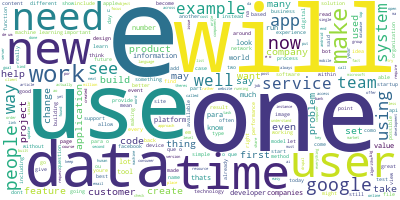

In [65]:
# Create a wordcloud of trimmed.text_no_punc_lower
long_string = ','.join(trimmed.text_no_punc_lower)
wc = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue')
wc.generate(long_string)
wc.to_image()

#### Prepare the data for LDA

In [66]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [67]:
import gensim
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksrs9\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [68]:
stopwords_en = stopwords.words('english')

In [114]:
# Define a function to convert sentences to words using gensim's simple_preprocess
def sentences_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

# define a function to remove stopwords
def remove_stopwords(words):
    return [w for w in words if w not in stopwords_en]

In [111]:
sentences = trimmed.text_description.values.tolist()

In [119]:
words_array = list(sentences_to_words(sentences))

In [120]:
words_array[0]

['all',
 'of',
 'this',
 'work',
 'is',
 'still',
 'very',
 'early',
 'the',
 'first',
 'full',
 'public',
 'version',
 'of',
 'the',
 'ethereum',
 'software',
 'was',
 'recently',
 'released',
 'and',
 'the',
 'system',
 'could',
 'face',
 'some',
 'of',
 'the',
 'same',
 'technical',
 'and',
 'legal',
 'problems',
 'that',
 'have',
 'tarnished',
 'bitcoin',
 'many',
 'bitcoin',
 'advocates',
 'say',
 'ethereum',
 'will',
 'face',
 'more',
 'security',
 'problems',
 'than',
 'bitcoin',
 'because',
 'of',
 'the',
 'greater',
 'complexity',
 'of',
 'the',
 'software',
 'thus',
 'far',
 'ethereum',
 'has',
 'faced',
 'much',
 'less',
 'testing',
 'and',
 'many',
 'fewer',
 'attacks',
 'than',
 'bitcoin',
 'the',
 'novel',
 'design',
 'of',
 'ethereum',
 'may',
 'also',
 'invite',
 'intense',
 'scrutiny',
 'by',
 'authorities',
 'given',
 'that',
 'potentially',
 'fraudulent',
 'contracts',
 'like',
 'the',
 'ponzi',
 'schemes',
 'can',
 'be',
 'written',
 'directly',
 'into',
 'the',
 'e

In [121]:
no_stopwords = [remove_stopwords(words) for words in words_array]

In [122]:
no_stopwords[0]

['work',
 'still',
 'early',
 'first',
 'full',
 'public',
 'version',
 'ethereum',
 'software',
 'recently',
 'released',
 'system',
 'could',
 'face',
 'technical',
 'legal',
 'problems',
 'tarnished',
 'bitcoin',
 'many',
 'bitcoin',
 'advocates',
 'say',
 'ethereum',
 'face',
 'security',
 'problems',
 'bitcoin',
 'greater',
 'complexity',
 'software',
 'thus',
 'far',
 'ethereum',
 'faced',
 'much',
 'less',
 'testing',
 'many',
 'fewer',
 'attacks',
 'bitcoin',
 'novel',
 'design',
 'ethereum',
 'may',
 'also',
 'invite',
 'intense',
 'scrutiny',
 'authorities',
 'given',
 'potentially',
 'fraudulent',
 'contracts',
 'like',
 'ponzi',
 'schemes',
 'written',
 'directly',
 'ethereum',
 'system',
 'sophisticated',
 'capabilities',
 'system',
 'made',
 'fascinating',
 'executives',
 'corporate',
 'america',
 'ibm',
 'said',
 'last',
 'year',
 'experimenting',
 'ethereum',
 'way',
 'control',
 'real',
 'world',
 'objects',
 'called',
 'internet',
 'things',
 'microsoft',
 'working',


Build a Dictionary

In [123]:
from gensim.corpora import Dictionary

data_dictionary = Dictionary(no_stopwords)
corpus = [data_dictionary.doc2bow(word_arr) for word_arr in no_stopwords]

In [105]:
# data_dictionary.doc2bow(words[0])
# len(words[0])
# words[0][13]

In [106]:
# corpus[0]

In [107]:
num_topics = 10

In [124]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus, 
    id2word=data_dictionary, 
    num_topics=num_topics, 
    random_state=42, 
    update_every=1, 
    chunksize=100, 
    passes=10, 
    alpha='auto', 
    per_word_topics=True
)

In [125]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.012*"new" + 0.008*"customer" + 0.008*"company" + 0.008*"companies" + '
  '0.008*"digital" + 0.007*"year" + 0.007*"business" + 0.007*"technology" + '
  '0.007*"customers" + 0.005*"services"'),
 (1,
  '0.003*"sha" + 0.002*"encrypt" + 0.001*"requesting" + 0.000*"decrypt" + '
  '0.000*"cipher" + 0.000*"prng" + 0.000*"cracking" + 0.000*"jjwt" + '
  '0.000*"bcrypt" + 0.000*"panther"'),
 (2,
  '0.012*"code" + 0.011*"use" + 0.007*"using" + 0.006*"api" + 0.005*"drupal" + '
  '0.005*"data" + 0.005*"also" + 0.005*"need" + 0.005*"example" + '
  '0.005*"java"'),
 (3,
  '0.030*"aws" + 0.017*"network" + 0.011*"ip" + 0.009*"http" + 0.009*"load" + '
  '0.008*"address" + 0.008*"instances" + 0.008*"vpc" + 0.008*"traffic" + '
  '0.008*"ec"'),
 (4,
  '0.010*"one" + 0.010*"time" + 0.008*"people" + 0.008*"like" + 0.008*"work" + '
  '0.008*"team" + 0.006*"way" + 0.006*"make" + 0.006*"get" + 0.005*"would"'),
 (5,
  '0.029*"app" + 0.025*"google" + 0.018*"android" + 0.016*"apple" + '
  '0.015*"users" +

In [126]:
doc_lda = lda_model[corpus]

Evaluation

In [127]:
lda_model.log_perplexity(corpus)

-9.142454737779303

In [128]:
doc_lda

In [129]:
doc_lda[0]

([(0, 0.5967025),
  (2, 0.06046356),
  (4, 0.24995418),
  (8, 0.0764533),
  (9, 0.01589272)],
 [(0, [4, 2]),
  (1, [0, 2]),
  (2, [0, 4]),
  (3, [0]),
  (4, [0, 4]),
  (5, [0, 8, 2]),
  (6, [0, 2, 8, 4]),
  (7, [0, 4, 2, 8]),
  (8, [2]),
  (9, [0, 9]),
  (10, [4, 0, 2, 8]),
  (11, [2, 0, 8]),
  (12, [0, 8, 2]),
  (13, [0, 4, 8, 2]),
  (14, [0, 4, 2, 8]),
  (15, [8, 0, 4]),
  (16, [0]),
  (17, [2]),
  (18, [0]),
  (19, [0, 4]),
  (20, [8, 2]),
  (21, [8, 0]),
  (22, [0]),
  (23, [0, 8, 4, 2]),
  (24, [4, 2, 8, 0]),
  (25, [4, 0, 8, 2]),
  (26, [0, 4]),
  (27, [0, 8]),
  (28, [2]),
  (29, [0]),
  (30, [0]),
  (31, [0]),
  (32, [4, 9]),
  (33, []),
  (34, [0, 4, 8]),
  (35, [0]),
  (36, [0, 4]),
  (37, [4, 0, 2, 8]),
  (38, [0, 4, 8, 2]),
  (39, []),
  (40, [0, 4]),
  (41, [0]),
  (42, [0]),
  (43, [0, 4, 8, 2, 9]),
  (44, [4, 0, 8, 9]),
  (45, [0]),
  (46, [0, 8, 2]),
  (47, [4, 8]),
  (48, [0]),
  (49, [0, 2]),
  (50, [4, 0, 8]),
  (51, [8, 0]),
  (52, [8]),
  (53, [0, 8, 4]),
  (54, [4

In [130]:
lda_model.get_document_topics(corpus[0])

[(0, 0.5967034),
 (2, 0.06046782),
 (4, 0.24995343),
 (8, 0.07644856),
 (9, 0.015893029)]

In [131]:
lda_model.show_topic(0)

[('new', 0.011757157),
 ('customer', 0.008443463),
 ('company', 0.008397211),
 ('companies', 0.008081194),
 ('digital', 0.0078710895),
 ('year', 0.0071024876),
 ('business', 0.0070922845),
 ('technology', 0.007092002),
 ('customers', 0.007069505),
 ('services', 0.004711236)]

In [33]:
trimmed.shape

(3122, 4)

In [34]:
y.shape

(3011, 2)

In [35]:
# x.columns

In [14]:
trimmed.shape

(3122, 3)

In [16]:
dups = trimmed[trimmed.duplicated(subset=['title', 'text_description'])]

In [18]:
dups.head(20)

,title,text_description,interaction_type
1,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,content_present
59,Governo Dilma é desaprovado por 69% e aprovado...,Pesquisa Ibope encomendada pela Confederação N...,content_pulled_out
84,Fooling The Machine,"Two groups, one at Berkeley University and ano...",content_pulled_out
86,Fooling The Machine,"Two groups, one at Berkeley University and ano...",content_present
87,Fooling The Machine,"Two groups, one at Berkeley University and ano...",content_pulled_out
88,Fooling The Machine,"Two groups, one at Berkeley University and ano...",content_present
89,Fooling The Machine,"Two groups, one at Berkeley University and ano...",content_present
90,Fooling The Machine,"Two groups, one at Berkeley University and ano...",content_pulled_out
210,Microsoft's mobile problem may not be a proble...,When Microsoft announced its Windows 10 strate...,content_pulled_out
225,"Eu não preciso de Unicórnios, preciso de Malam...","... afinal, Unicórnios não existem, não é mesm...",content_pulled_out
